# Regression Trees

This notebook implements the custom regression tree algorithm for regression on the Palmer Penguins dataset. Here, regression trees are used to predict the body mass of a sample based on input data for various numerical features, including bill length, bill width, and flipper length. The objective of this task is to validate the use of the custom regression tree class, and evaluate its performance for a multi-feature regression problem with a single target variable.

The following sections are included in this notebook:
1. **Library Imports**
- Importing the necessary modules, packages, and libraries
- Specifies dependencies and preferred versions
2. **Data Loading and Cleaning**
- Loads the Palmer Penguins dataset with relevant features
- Drops outliers, duplicates, and missing data
- Creates arrays for the features and target variable
3. **Data Visualization**
- Visualizes the correlation between features using a heatmap
- Visualizes the distribution of two features with the target on a 2D color plot
4. **Regression Tree Implementation (2 Features)**
- Implements the custom-built regression tree algorithm with two input features  
- Visualizes the regression results  
- Evaluates the results across multiple metrics  
5. **Regression Tree Implementation (Changing Parameters)**
- Implements the custom-built regression tree algorithm with various parameters (maximum depth, minimum samples to split)
- Examines the effect on model performance
6. **Regression Tree Implementation (Multiple Features)**
- Implements the custom-built regression tree algorithm with more than two features to ensure functionality
- Evaluates the results across multiple metrics
7. **Comparison with Existing Models**
- Runs the scikit-learn version of regression trees
- Compares the results with the custom-built class to verify the latter

*For a more comprehensive overview of the regression tree algorithm, code structure, and metrics used, see the associated [README](README.md).*

### Library Imports
This section imports the packages and modules required to run the regression tree algorithm. The following dependencies (with recommended versions) are required:
- Python 3.9.6
- Numpy 1.26.4
- Pandas 2.3.3
- Matplotlib 3.9.4
- Seaborn 0.13.2
- Sklearn 1.6.1

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from rice_ml.preprocess import *
from rice_ml.supervised_learning.decisiontrees import *
from rice_ml.postprocess.regressionpost import *

### Data Loading & Cleaning
*Loading, preprocessing, and dividing data*

The data used in this notebook comes from Palmer Penguins. Although this dataset is typically used for classification algorithms, it can be adapted to evaluate regression, as it contains a set of numerical features with some relation to one another. It has been selected for its simplicity and clear feature relationships, and because it requires several data cleaning steps that showcase the `rice_ml` preprocessing modules, including handling missing values. The features of interest in this example are *flipper length* (numeric), *bill length* (numeric), *bill depth* (numeric), and *body mass* (numeric and the target variable for regression). 

The data is first loaded as a Pandas DataFrame. Because no variables are categorical, no addition conversion of data is required.

In [62]:
# Loading the basic dataset and selecting features
penguins_df = sns.load_dataset("penguins")
penguin_features = penguins_df[[
    "bill_length_mm", 
    "bill_depth_mm", 
    "flipper_length_mm", 
    "body_mass_g"
]]

display(penguin_features)

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
3,NaN,NaN,NaN,NaN
4,36.7,19.3,193.0,3450.0
...,...,...,...,...
339,NaN,NaN,NaN,NaN
340,46.8,14.3,215.0,4850.0
341,50.4,15.7,222.0,5750.0
342,45.2,14.8,212.0,5200.0


The dataset contains some missing or NaN values (e.g., row 4) and may contain outlier or duplicate rows that will skew the results of the regression. To clean the data, we apply a series of preprocessing steps from the `rice_ml` preprocessing package, including dropping any rows with missing values, outliers, or that are identified to be duplicates of another.

In [63]:
# Cleaning the dataset (dropping rows with missing values, duplicates, or containing outliers)
penguin_features_cleaned_missing = missing_data(penguin_features, 'drop')
penguin_features_cleaned_outliers = outlier_identify(penguin_features_cleaned_missing, 'zscore', drop = True)
penguin_features_cleaned = duplicate_identify(penguin_features_cleaned_outliers, True)
print(f"Cleaned data (first five rows): \n {penguin_features_cleaned[0:5, :]}")

Cleaned data (first five rows): 
 [[  39.1   18.7  181.  3750. ]
 [  39.5   17.4  186.  3800. ]
 [  40.3   18.   195.  3250. ]
 [  36.7   19.3  193.  3450. ]
 [  39.3   20.6  190.  3650. ]]


Two rows have been removed during cleaning, and the dataset no longer contains NaN values. For use in regression trees and for ease of visualization, the dataset must be split into the target (*body mass*) and the remaining features.

In [91]:
# Creating two arrays
body_mass = penguin_features_cleaned[:, 3]
penguin_feature_data = penguin_features_cleaned[:, [0, 1, 2]]
print(f"Array for body mass (first five entries): \n {body_mass[0:5]} \n \n \
Array for penguin feature data (first five rows): \n {penguin_feature_data[0:5]}")

Array for body mass (first five entries): 
 [3750. 3800. 3250. 3450. 3650.] 
 
 Array for penguin feature data (first five rows): 
 [[ 39.1  18.7 181. ]
 [ 39.5  17.4 186. ]
 [ 40.3  18.  195. ]
 [ 36.7  19.3 193. ]
 [ 39.3  20.6 190. ]]


### Data Visualization
*Correlations and feature plotting*

Once the data has been appropriately cleaned, the relationships between variables can be visualized using a set of methods. We first visualize the correlations between features using a heatmap of a calculated correlation matrix, applied to the cleaned DataFrame that includes all relevant features. Doing so allows for the identification of features that are correlated with the target, and may thus be appropriate for regression using regression trees.

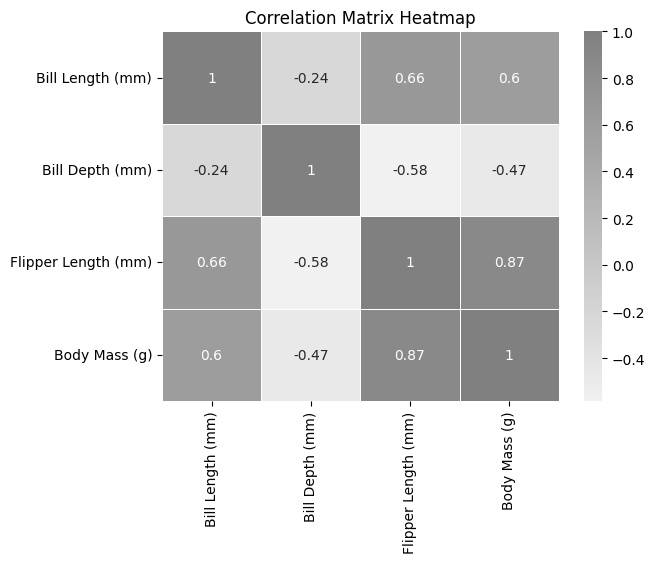

In [64]:
# Creating and plotting a correlation matrix with a heatmap
correlation_matrix = (pd.DataFrame(penguin_features_cleaned, columns = ['Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)'])).corr()
sns.heatmap(correlation_matrix, annot = True, cmap=sns.light_palette('gray', as_cmap=True), linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

To predict body mass, we select flipper length and bill length as the features of interest, given that these have the greatest correlation (0.87 and 0.6, respectively) with the target variable. The relationship between these features can be visualized using a two-dimensional plot and color mappings that correspond to a range of body mass values.

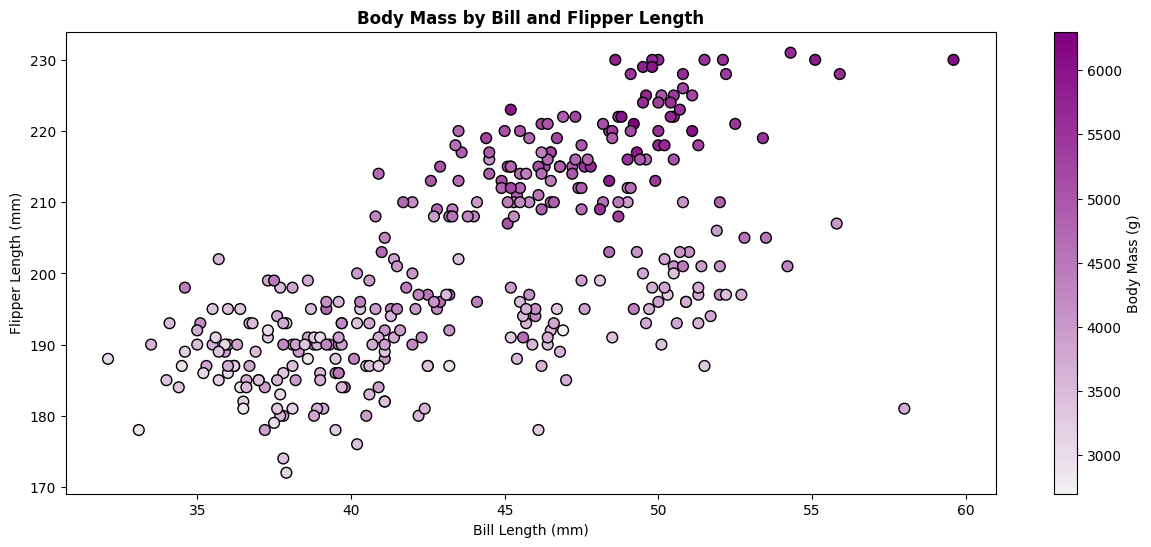

In [65]:
# Plotting bill length and flipper length, color-coded by body mass
plt.figure(figsize = (15, 6))
plt.scatter(penguin_feature_data[:, 0], penguin_feature_data[:, 2], c = body_mass, cmap = sns.light_palette('purple', as_cmap=True), s = 60, edgecolor = "k")
cbar = plt.colorbar()
cbar.set_label("Body Mass (g)")
plt.xlabel("Bill Length (mm)")
plt.ylabel("Flipper Length (mm)")
plt.title("Body Mass by Bill and Flipper Length", fontweight = 'bold')
plt.show()

These variables are positively correlated, as indicated in the correlation matrix. This relationship is also apparent on the above plot; as bill length and flipper length increase, body mass increases as well, with slightly more influence of the flipper length value than the bill length. The distribution of this data and the visible trends suggest that it is a good candidate for evaluating the custom regression tree algorithm.

### Regression Tree Implementation (2 Features)
*Regression using regression trees with two features*

This section implements the custom regression tree to predict body mass based on flipper length and bill length. It carries out the standardization, splitting, model fit, and prediction calculations.

Prior to fitting the regression tree, we normalize the feature data using z-scores for each feature, calculated using the `preprocessing` package. This reduces the possibility that the relative scale of the feature will impact model results, and is standard practice in supervised learning. Feature normalization rescales each feature to prevent skewing results based on feature magnitude, ensuring that no one feature will overly contribute to model predictions.

In [66]:
# Standardizing the features
penguin_feature_data_normal = z_score_standardize(penguin_feature_data[:, [0, 2]])
print(f"Standardized feature data (first five rows): \n {penguin_feature_data_normal[0:5, :]}")

Standardized feature data (first five rows): 
 [[-0.88449874 -1.41834665]
 [-0.81112573 -1.06225022]
 [-0.66437972 -0.42127665]
 [-1.32473679 -0.56371522]
 [-0.84781224 -0.77737308]]


Once the data has been scaled, it is split into testing and training arrays. This ensures that the model is not trained and tested on the same set of data, allowing for unbiased evaluation of model performance and preventing overfitting. The data is split in a 70/30 proportion such that the training data is 70% of the total dataset, and the testing data 30%. There are 342 samples in the cleaned dataset, so the training array should have approximately 239/240 samples and the testing should have 102/103. Because this is a regression problem with no class labels, stratification (as done in [decision trees](decision_tree_example.ipynb)) is not applicable, and the basic `train_test` function is used.

In [68]:
# Splitting the data into training and testing arrays
train_array, test_array, train_targets, test_targets = train_test(penguin_feature_data_normal, body_mass, random_state = 438)

# Verifying sizes of each array
print(f"Shape of training array: {train_array.shape}")
print(f"Shape of training targets: {train_targets.shape}")
print(f"Shape of testing array: {test_array.shape}")
print(f"Shape of testing targets: {test_targets.shape}")

Shape of training array: (239, 2)
Shape of training targets: (239,)
Shape of testing array: (103, 2)
Shape of testing targets: (103,)


We now perform regression using regression trees by creating an instance of the `regression_tree` class from the supervised learning package, and fitting it on the training data. The previously unseen test data is then provided to the fitted model to predict the body mass of a sample. 

This regression tree has the following specifications:
- **Maximum Depth:** None
- **Minimum Samples to Split:** 2

In [69]:
# Fitting the model
tree = regression_tree()
tree.fit(train_array, train_targets)

# Predicting body mass based on testing data
prediction = tree.predict(test_array)

When the model has been successfully fitted and returns the body mass predictions for the test data, we evaluate its performance using a variety of visualization and scoring methods. These include plotting the predictions, printing the tree and displaying the split boundaries, and calculating the MAE, MSE, RMSE, R2, and adjusted R2. For a description of these metrics, see this [README](README.md).

The plot below is a visualization of the regression tree predictions on the test data. The leftmost subplot displays the overall distribution of bill length and flipper length for the test data, color-coded for gold-standard body mass on a gradient scale. The rightmost subplot displays the same test data, but the gradient values are based on the value predictions from the regression tree.

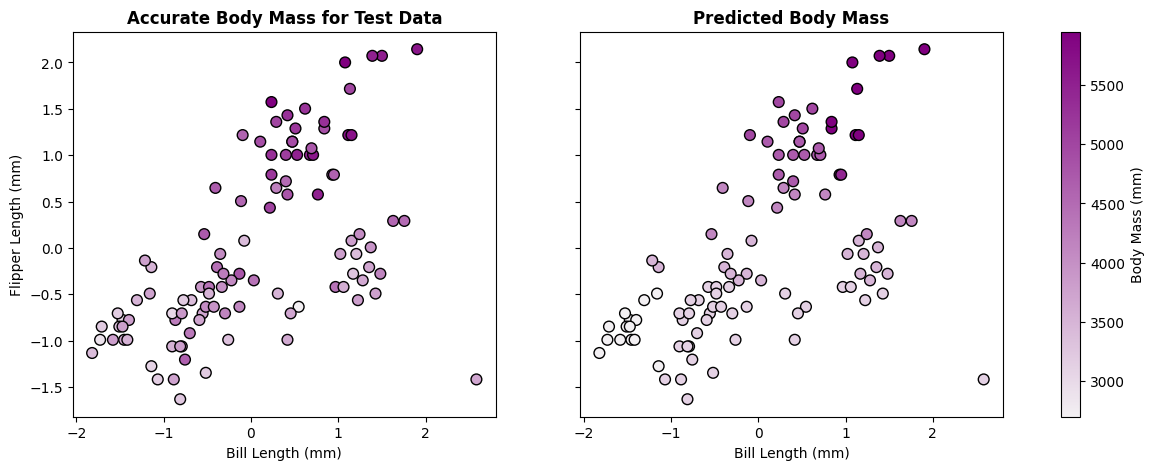

In [92]:
# Plotting bill length and flipper length for actual and predicted data, color-coded by body mass
fig, ax = plt.subplots(1, 2, figsize = (15, 5), sharey = True)
plot_1 = ax[0].scatter(test_array[:, 0], test_array[:, 1], c = test_targets, cmap = sns.light_palette('purple', as_cmap=True), s = 60, edgecolor = "k")
ax[0].set_xlabel("Bill Length (mm)")
ax[0].set_ylabel("Flipper Length (mm)")
ax[0].set_title("Accurate Body Mass for Test Data", fontweight = 'bold')

plot_2 = ax[1].scatter(test_array[:, 0], test_array[:, 1], c = prediction, cmap = sns.light_palette('purple', as_cmap=True), s = 60, edgecolor = "k")
ax[1].set_xlabel("Bill Length (mm)")
ax[1].set_title("Predicted Body Mass", fontweight = 'bold')

cbar = fig.colorbar(plot_1, ax = ax, location = 'right')
cbar.set_label("Body Mass (mm)")
plt.show()

The custom regression tree has a fairly good fit for the test data, with some discrepancies towards the upper side of the plot, where body mass is predicted as slightly lower than the actual value. The regression tree itself can be visualized to determine the values of features that guide splits, and the splits can be plotted to visualize the boundaries.

In [71]:
# Printing the regression tree
tree.print_tree()

Feature 1 <= 0.682622275221658
	Feature 1 <= -0.38566700845348223
		Feature 0 <= -1.0862745147295048
			Feature 1 <= -0.884202007501881
				Feature 0 <= -1.352251669646979
					Feature 1 <= -1.3827370065502798
						Feature 0 <= -1.6732585807542761
							Predict: 2900.0
							Predict: 2850.0
						Feature 0 <= -1.3981097998051646
							Feature 1 <= -1.1690791498152517
								Predict: 3325.0
								Feature 0 <= -1.4347963039317126
									Feature 0 <= -1.554027442342994
										Predict: 3050.0
										Feature 0 <= -1.4806544340898977
											Predict: 3150.0
											Predict: 3100.0
									Predict: 3225.0
							Feature 0 <= -1.3705949217102535
								Predict: 2850.0
								Predict: 3150.0
					Feature 0 <= -1.205505653140786
						Feature 0 <= -1.2513637832989715
							Feature 0 <= -1.2972219134571565
								Feature 1 <= -1.1690791498152517
									Predict: 3475.0
									Feature 0 <= -1.3339084175837048
										Predict: 3700.0
										Predict: 3800.0
								

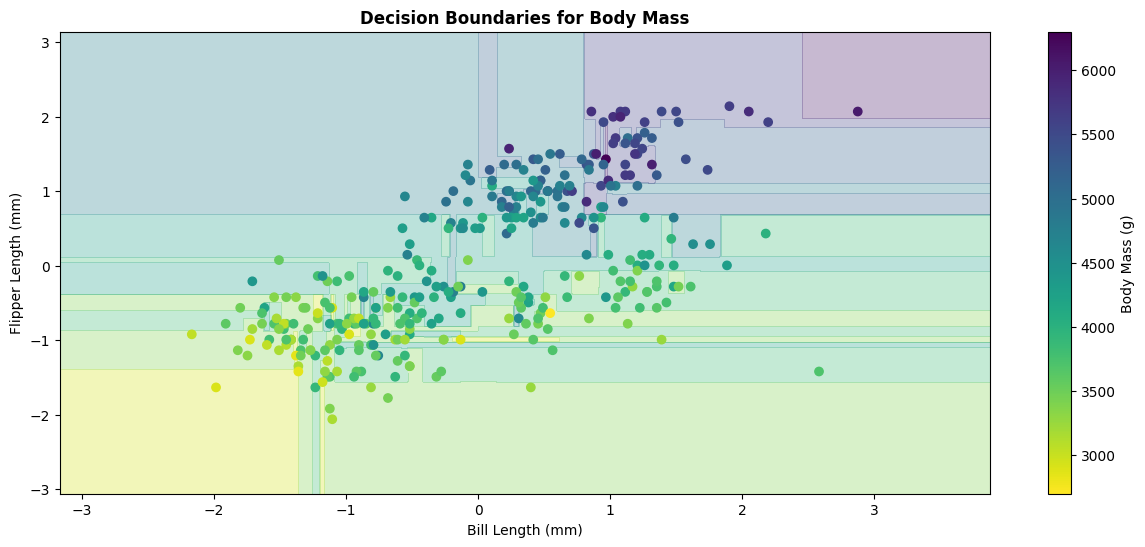

In [72]:
# Creating the meshgrid
x_min, x_max = penguin_feature_data_normal[:, 0].min() - 1, penguin_feature_data_normal[:, 0].max() + 1
y_min, y_max = penguin_feature_data_normal[:, 1].min() - 1, penguin_feature_data_normal[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))
grid_points = np.c_[xx.ravel(), yy.ravel()]
meshgrid_prediction = tree.predict(grid_points)
meshgrid_prediction = np.array(meshgrid_prediction, dtype = int).reshape(xx.shape)

# Plotting the decision boundaries
plt.figure(figsize=(15, 6))
cmap = ListedColormap(['pink', 'gray', '#CBC3E3'])
plt.contourf(xx, yy, meshgrid_prediction, alpha = 0.3, cmap = 'viridis_r')
colors = {0: 'pink', 1: 'gray', 2: '#CBC3E3'}
plt.scatter(penguin_feature_data_normal[:, 0], penguin_feature_data_normal[:, 1], c = body_mass, cmap = 'viridis_r')
cbar = plt.colorbar()
cbar.set_label("Body Mass (g)")
plt.xlabel("Bill Length (mm)")
plt.ylabel("Flipper Length (mm)")
plt.title("Decision Boundaries for Body Mass", fontweight = 'bold')
plt.show()

The regression tree results a series of splits that form a gradient for predicting the continuous variable of body mass, which aligns fairly well with the gold-standard target values for the data. The splits become more disjoint in areas where the body mass ranges significantly in value, including the lower left side of the plot and the upper middle. However, in general, the decision boundaries of the tree successfully support the efficacy of model performance.

For a more quantitative evaluation of the model, we produce the numerical evaluation metrics (MAE, MSE, RMSE, R2, and adjusted R2 for two features).

In [74]:
# Evaluating the model
print_model_metrics(prediction, test_targets, n_features = 2)

Model Metrics 
------------- 
MAE: 398.06 
MSE: 257233.01 
RMSE: 507.18 
R2: 0.59 
Adjusted R2: 0.58


The results of the evaluation metrics indicate that this regression tree is somewhat successful in predicting body mass from bill length and flipper length. The R2 and adjusted R2 are moderately high (~0.59), and are not significantly different from one another, indicating that the inclusion of the two features is not harming model predictions and is not unnecessary. Additionally, the MAE, MSE, and RMSE are expected for the scale of the data, which contains points in the thousands. Together, this validates the use of the custom regression tree for a two-feature regression problem, although with a goodness-of-fit that can likely be improved by additional features or changing hyperparameters.

### Regression Tree Implementation (Changing Parameters)
*Altering maximum depth and minimum samples to split*

This section implements the custom regression tree for predicting body mass based on bill length and flipper length, but systematically changes a parameter in the model to determine the effects on performance. It first evaluates the model for different maximum depths, using R2 as the primary metric.

In [77]:
# Arrays for maximum depth and R2
max_depth_values = np.arange(1, 21)
r2_max_depth = np.full(len(max_depth_values), np.nan)

# Fitting and scoring the model for each maximum depth
for i in range(len(max_depth_values)):
    tree = regression_tree(max_depth = int(max_depth_values[i]))
    tree.fit(train_array, train_targets)
    prediction = tree.predict(test_array)
    r2_score = r2(prediction, test_targets)
    r2_max_depth[i] = r2_score

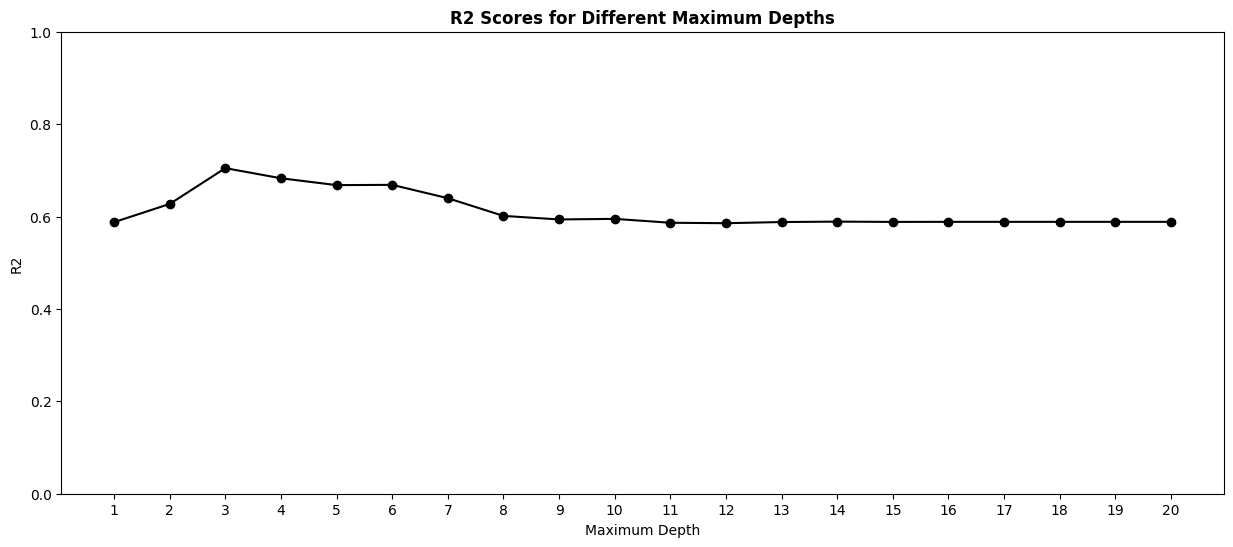

In [78]:
# Plotting the change in R2 across different maximum depths
plt.figure(figsize = (15, 6))
plt.plot(max_depth_values, r2_max_depth, 'black')
plt.scatter(max_depth_values, r2_max_depth, color = 'black')
plt.title("R2 Scores for Different Maximum Depths", fontweight = 'bold')
plt.xlabel("Maximum Depth")
plt.ylabel("R2")
plt.ylim(0.0, 1)
plt.xticks(range(1, 21))
plt.show()

The R2 score for the model begins low as the maximum depth is restricted to 1 to 2, but increases at around 3. From there, it begins to decrease until it reaches a plateau at a maximum depth of around 8 to 9, then remains at the same value regardless of the maximum depth variable. This suggests that changing maximum depth benefits model performance up to a point, but otherwise does not significantly improve the algorithm. For the remainder of the analysis, we specify a maximum depth of 3.

We now evaluate model performance with various values for the minimum samples required to split a node, with R2 as the metric.

In [81]:
# Arrays for minimum samples to split
min_samples_values = np.arange(1, 11)
r2_min_samples = np.full(len(min_samples_values), np.nan)

# Fitting and scoring the model for each minimum sample
for i in range(len(min_samples_values)):
    tree = regression_tree(max_depth = 3, min_samples_split = int(min_samples_values[i]))
    tree.fit(train_array, train_targets)
    prediction = tree.predict(test_array)
    r2_score = r2(prediction, test_targets)
    r2_min_samples[i] = r2_score

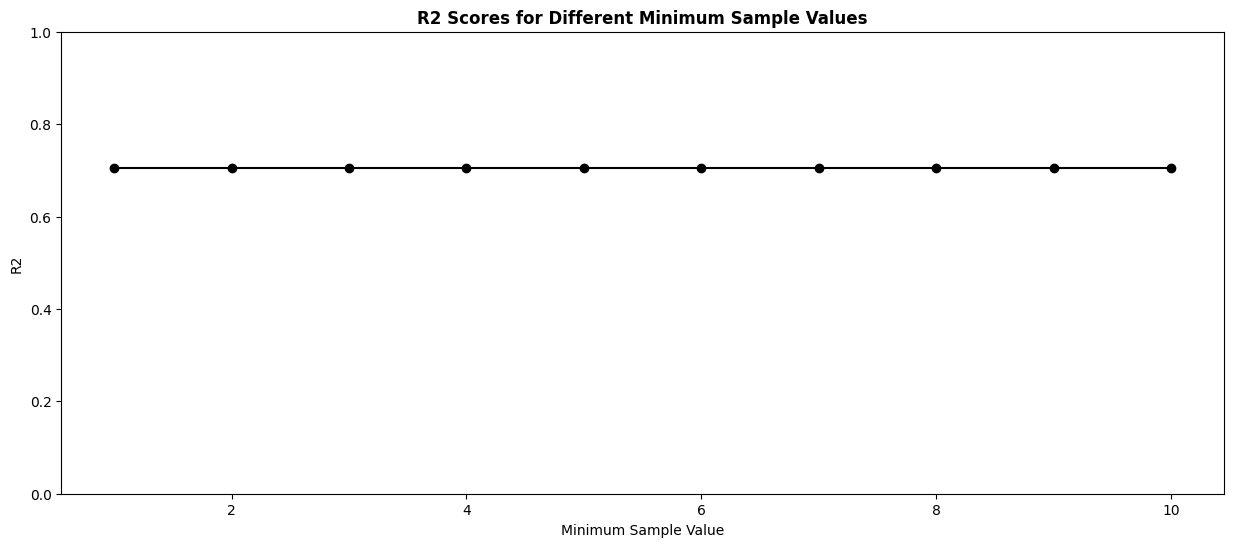

In [82]:
# Plotting the change in R2 across different minimum samples
plt.figure(figsize = (15, 6))
plt.plot(min_samples_values, r2_min_samples, 'black')
plt.scatter(min_samples_values, r2_min_samples, color = 'black')
plt.title("R2 Scores for Different Minimum Sample Values", fontweight = 'bold')
plt.xlabel("Minimum Sample Value")
plt.ylabel("R2")
plt.ylim(0.0, 1)
plt.show()

The value set for the minimum samples needed to split a node does not significantly impact performance of the model when the maximum depth is set to 3. Across all values, the R2 score remains at around 0.70, with no change seen for increasing or decreasing the metric. Therefore, we use the default minimum sample value of 2 for the remainder of the analysis.

### Regression Tree Implementation (Multiple Features)
*Regression using regression tree with multiple (three) features*

This section implements the custom regression tree class to predict body mass based on bill depth, bill length, and flipper length. As before, it carries out the standardization, splitting, model fit, and prediction calculations.

Prior to fitting the regression tree, we normalize the feature data using z-scores for each feature, again calculated using the `preprocessing` package. In this case, the entire feature data set (not simply the two selected features) is normalized and used in the regression tree. The data is then split into training (70%) and testing arrays (30%). Finally, a new instance of the regression tree class is created and fit with the training data, then used to predict values for samples in the testing data.

This regression tree algorithm has the following specifications:
- **Maximum Depth:** 3
- **Minimum Samples to Split**: 2

In [83]:
# Standardizing the features and target variable
penguin_feature_data_normal_mult = z_score_standardize(penguin_feature_data)
print(f"Standardized feature data (first five rows): \n {penguin_feature_data_normal_mult[0:5, :]}")

Standardized feature data (first five rows): 
 [[-0.88449874  0.78544923 -1.41834665]
 [-0.81112573  0.1261879  -1.06225022]
 [-0.66437972  0.43046236 -0.42127665]
 [-1.32473679  1.08972369 -0.56371522]
 [-0.84781224  1.74898502 -0.77737308]]


In [84]:
# Splitting the data into training and testing arrays
train_array_mult, test_array_mult, train_targets_mult, test_targets_mult = train_test(penguin_feature_data_normal_mult, body_mass, random_state = 438)

# Verifying sizes of each array
print(f"Shape of training array: {train_array_mult.shape}")
print(f"Shape of training targets: {train_targets_mult.shape}")
print(f"Shape of testing array: {test_array_mult.shape}")
print(f"Shape of testing targets: {test_targets_mult.shape}")

Shape of training array: (239, 3)
Shape of training targets: (239,)
Shape of testing array: (103, 3)
Shape of testing targets: (103,)


In [85]:
# Fitting the model
tree_mult = regression_tree(max_depth = 3, min_samples_split = 2)
tree_mult.fit(train_array_mult, train_targets_mult)

# Predicting body mass based on testing data
prediction_mult = tree_mult.predict(test_array_mult)

Model evaluation for three features is done using the quantitative metrics, as well as printing the regression tree.

In [86]:
# Evaluating the model
print_model_metrics(prediction_mult, test_targets_mult, n_features = 2)

Model Metrics 
------------- 
MAE: 359.18 
MSE: 193741.15 
RMSE: 440.16 
R2: 0.69 
Adjusted R2: 0.68


In [87]:
# Printing the regression tree
tree_mult.print_tree()

Feature 2 <= 0.682622275221658
	Feature 2 <= -0.38566700845348223
		Feature 1 <= 1.115079892302055
			Predict: 3507.9896907216494
			Predict: 4125.0
		Feature 1 <= -0.5584296375544627
			Predict: 4468.055555555556
			Predict: 3991.4634146341464
	Feature 0 <= 0.8030804477877292
		Feature 1 <= -0.9387727125218526
			Predict: 4741.071428571428
			Predict: 5082.142857142857
		Feature 2 <= 1.1099379886917142
			Predict: 5245.833333333333
			Predict: 5606.451612903225


This model predicts body mass with a higher R2 and adjusted R2 than the two-feature model, as well as a lower MAE, MSE, and RMSE. This suggests that including the additional feature (bill depth) positively contributes to the performance of the model, as does limiting the maximum depth of the model. Consequently, the custom regression tree has been shown to run without error and produce reliable results for multi-feature regression.

### Comparison with Existing Models
*Comparison with scikit-learn regression tree*

In order to ensure that the custom-built regression tree algorithm is functioning as intended and providing expected results, it is useful to compare its performance to a regression tree from established code. In this section, we rerun the analysis with all three features using the scikit-learn regression tree with a matching maximum depth (3) and minimum samples to split (2) to verify the results of the custom model.

In [89]:
# Creating a decision tree regressor using scikit-learn
from sklearn.tree import DecisionTreeRegressor
tree_sk = DecisionTreeRegressor(max_depth = 3, min_samples_split = 2)
tree_sk.fit(train_array_mult, train_targets_mult)
prediction_sk = tree_sk.predict(test_array_mult)

In [90]:
# Printing the model metrics for the scikit-learn regression tree
print_model_metrics(prediction_sk, test_targets_mult)

Model Metrics 
------------- 
MAE: 365.80 
MSE: 197892.19 
RMSE: 444.85 
R2: 0.68 
Adjusted R2: 0.68


The scikit-learn regression tree has an MAE, MSE, RMSE, R2, and adjusted R2 that is essentially identical to that of the custom-built regression tree; the R2 value for the custom tree is technically slightly greater than the scikit-learn version. Therefore, the custom `rice_ml` regression tree is able to handle multi-feature regression problems to a professional standard - although the features selected may not be optimally suitable for regression analysis (with an R2 value < 0.70), the validation of the custom class suggests a correctly functioning algorithm in itself.